##1: Setting the Environment

In [ ]:
#@title Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Setting a folder as working directory
%cd /content/drive/My Drive/Sentiment Analysis Using LSTM
!ls

/content/drive/My Drive/Sentiment Analysis Using LSTM
b3_tokenizer.json			  glove.6B.100d.txt	      testing.xlsx
depression_dataset_reddit_cleaned.csv	  reddit_sampled_testing.csv  trained_model.h5
depression_dataset_reddit_normalized.csv  testing.csv


In [ ]:
#@title Install Env
#pip install tensorflow
#!pip install keras
!pip install keras_preprocessing

nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#@title Import Env
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

from keras_preprocessing.sequence import pad_sequences

import seaborn as sns

import io
import json

from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt

from keras_preprocessing.text import tokenizer_from_json

##2: Working on the Dataset

In [ ]:
#@title Importing the Reddit Comments Dataset
reddit_comments = pd.read_csv("depression_dataset_reddit_cleaned.csv")

In [ ]:
#@title Dataset Exploration
reddit_comments.shape
reddit_comments.head(5)

clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1
3  i ve kind of stuffed around a lot in my life d...              1
4  sleep is my greatest and most comforting escap...              1

In [ ]:
#@title Are there any Null Values?
reddit_comments.isnull().values.any()

False

<Axes: xlabel='is_depression', ylabel='count'>

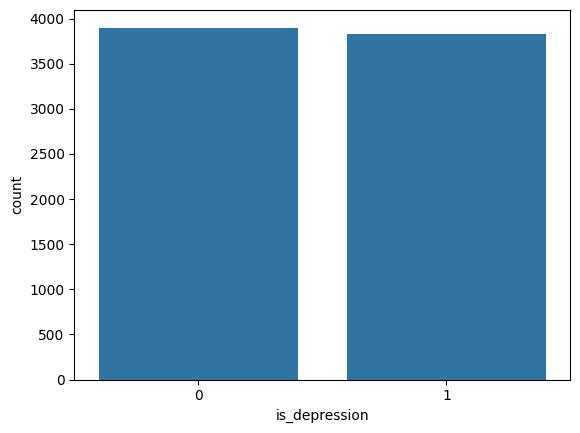

In [ ]:
#@title What is the distribution like?

sns.countplot(x='is_depression', data=reddit_comments)

## 3: Data Preprocessing



In [ ]:
#@title What does the comments look like?

reddit_comments["clean_text"][2]

'anyone else instead of sleeping more when depressed stay up all night to avoid the next day from coming sooner may be the social anxiety in me but life is so much more peaceful when everyone else is asleep and not expecting thing of you'

In [ ]:
#@title Function to preprocess the comments data

def preprocess_text(sen):
  sentence = sen.lower()

  #remove punctuations and numbers

  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  #remove single characters
  sentence = re.sub(r"\s+[a-zA-Z]\s", ' ',sentence)

  #remove multiple spaces
  sentence = re.sub(r'\s+', ' ',sentence)

  #remove stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  sentence = pattern.sub('', sentence)

  return sentence

In [ ]:
#@title Calling preprocess_text function on movie_reviews

preprocessed_comments = []
sentences = reddit_comments['clean_text']
for sen in sentences:
  preprocessed_comments.append(preprocess_text(sen))

In [ ]:
#@title Sample Cleaned Up Comments

print(preprocessed_comments[5])

year old turning soon month live constant dread passion goal special achievement life never relationship know want called life everything feel exhausting cry sleep everyday also feel extremely disconnected others fit even though try hardest decent human try treat others kindness respect good listener help people need help work hard exercise daily basis take good care appearance matter hard try present best still feel fit still feel empty unworthy unwanted want something could proud matter still never feel good enough even crave meaningful connection want someone share spend day laugh cry share handmade gift see smile face someone feel like home feeling homeless time want feel loved cared wanted like idea meaningful connection head even barely hold conversation whenever try talk someone feel extremely drained stuck rabbit hole feeling extremely lonely energy talk time know feel like failure human want completely disappear thanks reading long rant anywhere else get mind 


In [ ]:
y = reddit_comments['is_depression']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_comments, y, test_size=0.20, random_state=42)

## 4: Create Embedding Layer

In [ ]:
#@title Embedding Layer words in numeric form

# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
#@title Saving

tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
#@title Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

16598

In [ ]:
#@title Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
#@title Load GloVe word embeddings and create as Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
#@title Embedding Matrix with 100 columns

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
#@title Embedding Matrix Shape

embedding_matrix.shape

(16598, 100)

##5: Model Training

In [ ]:
#@title Recurrent Neural Network (LSTM)

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
#@title Model compiling


lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1659800   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1777177 (6.78 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 1659800 (6.33 MB)
_________________________________________________________________
None


In [ ]:
#@title Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
39/39 [==============================] - 23s 388ms/step - loss: 0.1341 - acc: 0.9842 - val_loss: 7.1780e-05 - val_acc: 1.0000
Epoch 2/6
39/39 [==============================] - 14s 370ms/step - loss: 8.6431e-04 - acc: 0.9996 - val_loss: 4.1410e-05 - val_acc: 1.0000
Epoch 3/6
39/39 [==============================] - 14s 368ms/step - loss: 8.0239e-04 - acc: 0.9996 - val_loss: 3.2578e-05 - val_acc: 1.0000
Epoch 4/6
39/39 [==============================] - 15s 377ms/step - loss: 7.3932e-04 - acc: 0.9996 - val_loss: 2.7149e-05 - val_acc: 1.0000
Epoch 5/6
39/39 [==============================] - 14s 370ms/step - loss: 3.5693e-04 - acc: 0.9998 - val_loss: 2.3463e-05 - val_acc: 1.0000
Epoch 6/6
39/39 [==============================] - 14s 368ms/step - loss: 3.3022e-04 - acc: 0.9998 - val_loss: 2.0677e-05 - val_acc: 1.0000


In [ ]:
#@title Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

49/49 [==============================] - 4s 75ms/step - loss: 9.3887e-04 - acc: 0.9994


In [ ]:
#@title Model Score

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0009388697217218578
Test Accuracy: 0.9993535876274109


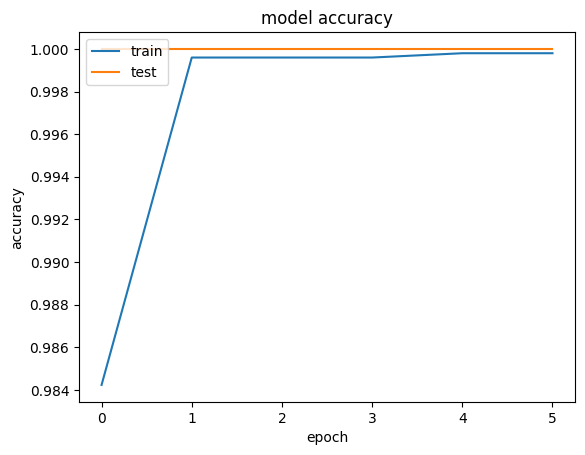

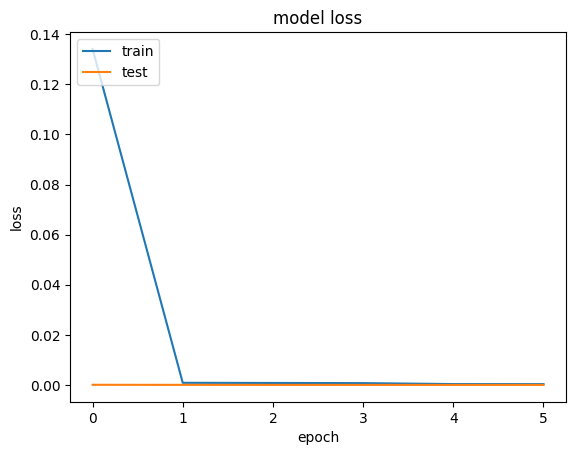

In [ ]:
#title Model performance charts

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"trained_model.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 6: Custom LSTM Layer

In [ ]:
#@title Library Import

import tensorflow as tf
from tensorflow.keras.layers import Layer, Embedding, Dense
import numpy as np
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords

In [ ]:
#@title Define the CustomLSTM layer
class CustomLSTM(Layer):
    def __init__(self, num_units):
        super(CustomLSTM, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.Wf = self.add_weight(shape=(input_dim + self.num_units, self.num_units), initializer='random_normal', trainable=True)
        self.bf = self.add_weight(shape=(1, self.num_units), initializer='random_normal', trainable=True)
        self.Wi = self.add_weight(shape=(input_dim + self.num_units, self.num_units), initializer='random_normal', trainable=True)
        self.bi = self.add_weight(shape=(1, self.num_units), initializer='random_normal', trainable=True)
        self.Wo = self.add_weight(shape=(input_dim + self.num_units, self.num_units), initializer='random_normal', trainable=True)
        self.bo = self.add_weight(shape=(1, self.num_units), initializer='random_normal', trainable=True)
        self.Wc = self.add_weight(shape=(input_dim + self.num_units, self.num_units), initializer='random_normal', trainable=True)
        self.bc = self.add_weight(shape=(1, self.num_units), initializer='random_normal', trainable=True)

    def call(self, inputs):
      batch_size = tf.shape(inputs)[0]
      time_steps = tf.shape(inputs)[1]
      states = [tf.zeros((batch_size, self.num_units)), tf.zeros((batch_size, self.num_units))]  # Initialize states
      for t in range(time_steps):
        input_t = inputs[:, t, :]
        h, c = states
        combined = tf.concat([input_t, h], axis=1)
        f = tf.sigmoid(tf.matmul(combined, self.Wf) + self.bf)
        i = tf.sigmoid(tf.matmul(combined, self.Wi) + self.bi)
        o = tf.sigmoid(tf.matmul(combined, self.Wo) + self.bo)
        c_candidate = tf.tanh(tf.matmul(combined, self.Wc) + self.bc)
        c = f * c + i * c_candidate
        h = o * tf.tanh(c)
        states = [h, c]
      return h

In [ ]:
#@title Define preprocessing function
def preprocess_text(sen):
    sentence = sen.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence

In [ ]:
#@title Preprocess comments and Prepare Data
preprocessed_comments = []
sentences = reddit_comments['clean_text']
for sen in sentences:
    preprocessed_comments.append(preprocess_text(sen))

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(preprocessed_comments, y, test_size=0.20, random_state=42)

In [ ]:
# Tokenize and pad sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
max_len = max(len(seq) for seq in X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [ ]:
#@title Define model
vocab_length = len(tokenizer.word_index) + 1
embedding_dim = 100  # Change this to match your embedding dimension
embedding_matrix = np.zeros((vocab_length, embedding_dim))  # Initialize embedding matrix

embedding_layer = Embedding(input_dim=vocab_length, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)
lstm_model = tf.keras.Sequential([
    embedding_layer,
    CustomLSTM(128)
])
lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
#@title Compile model, Train Model, Evaluate Model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

# Train model
batch_size = 128
epochs = 6
history = lstm_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

# Evaluate model
score = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1659800   
                                                                 
 custom_lstm (CustomLSTM)    (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1777177 (6.78 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 1659800 (6.33 MB)
_________________________________________________________________
None
Epoch 1/6
39/39 [==============================] - 333s 8s/step - loss: 0.2272 - acc: 0.9741 - val_loss: 5.9429e-05 - val_acc: 1.0000
Epoch 2/6
39/39 [==============================] - 334s 9s/step - loss: 4.4182e-05 - acc: 1.0000 - val_loss: 3.7516e-05 - val_acc: 1.000